# Utilisation de GAN pour faire du semi-supervisé

Inspiré du modèle GAN-BERT  [(cf article décrivant le modèle)](https://www.aclweb.org/anthology/2020.acl-main.191/)

Le modèle GAN-BERT est un modèle de classification de texte qui ajoute un GAN pour générer des pseudo-exemples, avec un discriminateur qui doit à la fois distinguer entre vrai et faux exemples, et donner la classe des vrais exemples.

Le GAN est combiné à une approche semi-supervisée, les instances non étiquettées étant utilisées pour entrainer la partie adversarielle du modèle.



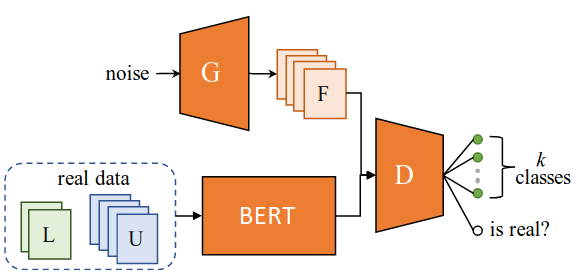



Le générateur prendra en entrée un bruit gaussien (normal) de dimension m, et génèrera un vecteur de dimension égale aux sorties du modèle BERT (n=512).
Le discriminateur prédit entre les k classes du problème + vrai/faux exemple.

Dans ce TP nous allons réaliser les tâches suivantes:

- implémenter un générateur et un discriminateur (ou plusieurs variantes)
- entrainer le modèle, en choisissant les bons réglages
- étudier l'influence du nombre d'exemples supervisés/non supervisés sur le résultat final
- comparer le modèle GAN avec le modèle de base

## Préparation

In [2]:
# !pip install transformers
!pip --version

import torch
import io
import torch.nn.functional as F
import random
import numpy as np
import time
import math
import datetime
import torch.nn as nn
from transformers import *
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import pandas as pds
from tqdm import tqdm
## Contrôle de la reproductibilité
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(seed_val)

pip 25.0.1 from C:\Users\norph\Documents\M2IAFA\IA 3\TP Noté\.venv\Lib\site-packages\pip (python 3.12)



c:\Users\norph\Documents\M2IAFA\IA 3\TP Noté\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('Calcul sur GPU')
else:
    print('Calculs sur CPU')
    device = torch.device("cpu")

Calcul sur GPU


### Paramètres


In [4]:
#--------------------------------
#  Transformer
#--------------------------------
max_seq_length = 64
batch_size = 64

#--------------------------------
#  GAN-BERT
#--------------------------------
# number of hidden layers in the generator,
# each of the size of the output space
num_hidden_layers_g = 1;
# number of hidden layers in the discriminator,
# each of the size of the input space
num_hidden_layers_d = 1;
# size of the generator's input noisy vectors
noise_size = 100
# dropout to be applied to discriminator's input vectors
out_dropout_rate = 0.2

# Replicate labeled data to balance poorly represented datasets,
# e.g., less than 1% of labeled material
apply_balance = False

#--------------------------------
#  Optimiseur
#--------------------------------
learning_rate_discriminator = 5e-5
learning_rate_generator = 5e-5
epsilon = 1e-8
num_train_epochs = 5
multi_gpu = True
# Scheduler
apply_scheduler = False
warmup_proportion = 0.1
# Print
print_each_n_step = 10

#--------------------------------------
#  Choix du modèle de langue de base
#--------------------------------------
# attention aux dimensions de sortie

model_name = "bert-base-cased"
#model_name = "bert-base-uncased"
#model_name = "roberta-base"
#model_name = "albert-base-v2"
#model_name = "xlm-roberta-base"
# bert-large, mais compressé -> 3x plus rapide mais perf dégradées. utile pour tester rapidement votre code
#model_name = "amazon/bort"

#--------------------------------
#  TREC QC Dataset
#--------------------------------
# !wget https://www.irit.fr/~Philippe.Muller/data_gan.zip
# !unzip data_gan.zip

#
labeled_file = "./data/labeled.tsv"
unlabeled_file = "./data/unlabeled.tsv"
test_filename = "./data/test.tsv"

# Deux niveaux de granularité des labels

label_list = ["UNK_UNK","ABBR_abb", "ABBR_exp", "DESC_def", "DESC_desc",
              "DESC_manner", "DESC_reason", "ENTY_animal", "ENTY_body",
              "ENTY_color", "ENTY_cremat", "ENTY_currency", "ENTY_dismed",
              "ENTY_event", "ENTY_food", "ENTY_instru", "ENTY_lang",
              "ENTY_letter", "ENTY_other", "ENTY_plant", "ENTY_product",
              "ENTY_religion", "ENTY_sport", "ENTY_substance", "ENTY_symbol",
              "ENTY_techmeth", "ENTY_termeq", "ENTY_veh", "ENTY_word", "HUM_desc",
              "HUM_gr", "HUM_ind", "HUM_title", "LOC_city", "LOC_country",
              "LOC_mount", "LOC_other", "LOC_state", "NUM_code", "NUM_count",
              "NUM_date", "NUM_dist", "NUM_money", "NUM_ord", "NUM_other",
              "NUM_perc", "NUM_period", "NUM_speed", "NUM_temp", "NUM_volsize",
              "NUM_weight"]

macro_label_list = list(set([x.split("_")[0] for x in label_list]))
macro_label_list

['ABBR', 'ENTY', 'LOC', 'HUM', 'UNK', 'DESC', 'NUM']

On récupère le modèle de base




In [5]:
transformer = AutoModel.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file config.json from cache at C:\Users\norph\.cache\huggingface\hub\models--bert-base-cased\snapshots\cd5ef92a9fb2f889e972770a36d4ed042daf221e\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file model.safetensors from cache at C:\Users\norph\.cache\huggingface\hub\models--bert-base-cased\snapshots\cd5ef92a9fb2f889e972770a36d4ed042daf22

### Chargement du jeu de données



In [6]:
def get_qc_examples(input_file,macro_label=False):
  """Creates examples for the training and dev sets."""
  examples = []

  with open(input_file, 'r') as f:
      contents = f.read()
      file_as_list = contents.splitlines()
      for line in file_as_list[1:]:
          split = line.split(" ")
          question = ' '.join(split[1:])

          text_a = question
          inn_split = split[0].split(":")
          if macro_label:
            label = inn_split[0]
          else:
            label = inn_split[0] + "_" + inn_split[1]
          examples.append((text_a, label))
      f.close()

  return examples

In [7]:
# quel jeu d'étiquettes: gros grain (MACRO) ou pas
MACRO = True

labeled_examples = get_qc_examples(labeled_file,macro_label=MACRO)
unlabeled_examples = get_qc_examples(unlabeled_file,macro_label=MACRO)
test_examples = get_qc_examples(test_filename,macro_label=MACRO)

**Question**

Regardez la distribution des classes considérées (macro ou pas)

Le problème parait-il équilibré ?

En examinant les deux graphiques, on peut observer que la distribution des classes n'est pas équilibrée.
Dans le premier graphique, qui montre la distribution sans regroupement (nomacro), certaines classes comme "HUM_ind" sont nettement plus fréquentes que d'autres, telles que "ABBR_abb" ou "NUM_volsize". Cela indique une forte disparité dans la répartition des classes.
Le second graphique, qui regroupe les classes (macro), montre également un déséquilibre, bien que moins prononcé. La classe "HUM" est la plus représentée, tandis que "ABBR" est la moins fréquente.

<div style="display: flex; justify-content: space-around;">
    <img src="distrib_macro.png" alt="Distribution avec macro" style="width: 40%;">
    <img src="distrib_nomacro.png" alt="Distribution sans macro" style="width: 40%;">
</div>

In [8]:
import pandas as pds

In [9]:
label_distrib = pds.Series((l for (x,l)in labeled_examples))

<Axes: >

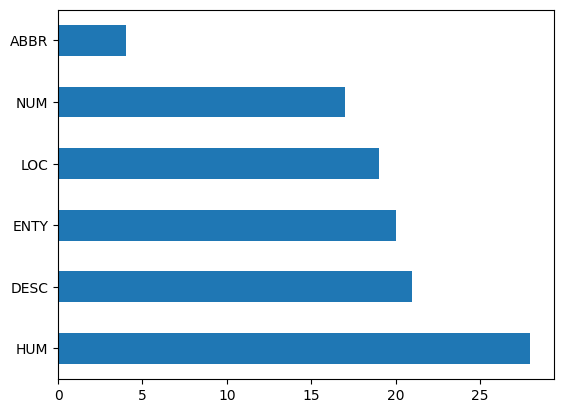

In [10]:
label_distrib.value_counts().plot(kind="barh")

**Question**

Quelle est la proportion d'exemples non annotés par rapport aux exemples annotés ?




In [11]:
num_labeled = len(labeled_examples)
num_unlabeled = len(unlabeled_examples)

proportion_unlabeled =  num_unlabeled / (num_unlabeled + num_labeled)

print(f"Nombre d'exemples annotés : {num_labeled}")
print(f"Nombre d'exemples non annotés : {num_unlabeled}")
print(f"Proportion d'exemples non annotés par rapport aux annotés : {proportion_unlabeled*100:.2f} %")

Nombre d'exemples annotés : 109
Nombre d'exemples non annotés : 5343
Proportion d'exemples non annotés par rapport aux annotés : 98.00 %


In [12]:
# code original de ganbert; ne pas modifier cette partie
def generate_data_loader(input_examples, label_masks, label_map, do_shuffle = False, balance_label_examples = False):
  '''
  Generate a Dataloader given the input examples, eventually masked if they are
  to be considered NOT labeled.
  '''
  examples = []

  # Count the percentage of labeled examples
  num_labeled_examples = 0
  for label_mask in label_masks:
    if label_mask:
      num_labeled_examples += 1
  label_mask_rate = num_labeled_examples/len(input_examples)

  # if required it applies the balance
  for index, ex in enumerate(input_examples):
    if label_mask_rate == 1 or not balance_label_examples:
      examples.append((ex, label_masks[index]))
    else:
      # IT SIMULATES A LABELED EXAMPLE
      if label_masks[index]:
        balance = int(1/label_mask_rate)
        balance = int(math.log(balance,2))
        if balance < 1:
          balance = 1
        for b in range(0, int(balance)):
          examples.append((ex, label_masks[index]))
      else:
        examples.append((ex, label_masks[index]))

  #-----------------------------------------------
  # Generate input examples to the Transformer
  #-----------------------------------------------
  input_ids = []
  input_mask_array = []
  label_mask_array = []
  label_id_array = []

  # Tokenization
  for (text, label_mask) in examples:
    encoded_sent = tokenizer.encode(text[0], add_special_tokens=True, max_length=max_seq_length, padding="max_length", truncation=True)
    input_ids.append(encoded_sent)
    label_id_array.append(label_map[text[1]])
    label_mask_array.append(label_mask)

  # Attention to token (to ignore padded input wordpieces)
  for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    input_mask_array.append(att_mask)
  # Convertion to Tensor
  input_ids = torch.tensor(input_ids)
  input_mask_array = torch.tensor(input_mask_array)
  label_id_array = torch.tensor(label_id_array, dtype=torch.long)
  label_mask_array = torch.tensor(label_mask_array)

  # Building the TensorDataset
  dataset = TensorDataset(input_ids, input_mask_array, label_id_array, label_mask_array)

  if do_shuffle:
    sampler = RandomSampler
  else:
    sampler = SequentialSampler

  # Building the DataLoader
  return DataLoader(
              dataset,  # The training samples.
              sampler = sampler(dataset),
              batch_size = batch_size) # Trains with this batch size.

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

On prépare le générateur de batchs.

**Question**

Ajouter un paramètre qui permet de régler la quantité de données "unlabelled" utilisé, et qui l'applique ici (en gardant des exemples au hasard dans ceux d'origine)


In [13]:
if MACRO:
  label_list = macro_label_list

label_map = {}
for (i, label) in enumerate(label_list):
  label_map[label] = i
#------------------------------
#   Load the train dataset
#------------------------------
train_examples = labeled_examples
#The labeled (train) dataset is assigned with a mask set to True
train_label_masks = np.ones(len(labeled_examples), dtype=bool)

unlabeled_fraction = 1.0

#If unlabel examples are available
if unlabeled_examples:
  num_unlabeled = int(len(unlabeled_examples) * unlabeled_fraction)
  selected_unlabeled_examples = random.sample(unlabeled_examples, num_unlabeled)

  train_examples = train_examples + selected_unlabeled_examples
  #The unlabeled (train) dataset is assigned with a mask set to False
  tmp_masks = np.zeros(num_unlabeled, dtype=bool)
  train_label_masks = np.concatenate([train_label_masks,tmp_masks])

train_dataloader = generate_data_loader(train_examples, train_label_masks, label_map, do_shuffle = True, balance_label_examples = apply_balance)

#------------------------------
#   Load the test dataset
#------------------------------
#The labeled (test) dataset is assigned with a mask set to True
test_label_masks = np.ones(len(test_examples), dtype=bool)

test_dataloader = generate_data_loader(test_examples, test_label_masks, label_map, do_shuffle = False, balance_label_examples = False)

C:\Users\norph\AppData\Local\Temp\ipykernel_16776\2882914003.py:55: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  label_mask_array = torch.tensor(label_mask_array)


**Question**

Définir un générateur et un discriminateur.

Vous pouvez suivre la description donnée dans l'article d'origine https://www.aclweb.org/anthology/2020.acl-main.191/

Pour commencer vous pouvez faire des modules simples, sans dropout et avec une seule couche "cachée"

In [14]:
#------------------------------
#  Generator
#------------------------------
class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        
        layers.append(nn.Linear(noise_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_sizes[0], output_size))
        
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

#------------------------------
#   Discriminator
#
#------------------------------
class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        # self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []

        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        self.layers = nn.Sequential(*layers)
        self.logit = nn.Linear(hidden_sizes[-1], num_labels+1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_rep):
        # input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs

In [15]:
# on récupère la config du modèle de base (ex BERT) pour avoir les dimensions produites
config = AutoConfig.from_pretrained(model_name)
hidden_size = int(config.hidden_size)

hidden_levels_g = [hidden_size for i in range(0, num_hidden_layers_g)]
hidden_levels_d = [hidden_size for i in range(0, num_hidden_layers_d)]

#-------------------------------------------------
#   Instantiate the Generator and Discriminator
#-------------------------------------------------
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels_g, dropout_rate=out_dropout_rate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels_d, num_labels=len(label_list), dropout_rate=out_dropout_rate)

# Put everything in the GPU if available
if torch.cuda.is_available():
  generator.cuda()
  discriminator.cuda()
  transformer.cuda()
  if multi_gpu:
    transformer = torch.nn.DataParallel(transformer)

# print(config)

loading configuration file config.json from cache at C:\Users\norph\.cache\huggingface\hub\models--bert-base-cased\snapshots\cd5ef92a9fb2f889e972770a36d4ed042daf221e\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.49.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}



## Entrainement du modèle

**Questions**

1. Ecrire la génération de l'entrée aléatoire du Générateur en accord avec l'article (indice: regarder l'aide de la méthode uniform_ sur les tenseurs)

2. Identifiez les parties de la loss décrite dans l'article. Voyez vous des différences ?

Dans l'article, la loss du discriminateur est composée de deux termes. Le premier terme concerne la loss sur les données réelles, encourageant le discriminateur à prédire 1 pour ces données. Le second terme porte sur la loss des données générées, poussant le discriminateur à prédire 0 pour celles-ci.

Dans le code, quant à lui, utilise trois termes pour la loss du discriminateur. On y trouve un terme de loss supervisée pour les données étiquetées (`D_L_Supervised`), ainsi que deux termes de loss non supervisée : un pour les données réelles (`D_L_unsupervised1U`) et un pour les données générées (`D_L_unsupervised2U`).

De plus dans le code il y a un ajout d'un petit terme epsilon lors du calcul des logarithmes pour éviter les problèmes numériques qui n'est pas mentionner dans l'article.

L'article définit la loss du générateur de manière à ce que celui-ci cherche à la minimiser en trompant le discriminateur pour qu'il prédise 1 pour les données générées.

Pour finir dans le code ci-dessous, il ajoute à cette loss du générateur un terme de régularisation supplémentaire, `g_feat_reg` qui n'est pas mentionner dans l'article


3. A quoi sert la ligne suivante:
  ```python
  discriminator_input = torch.cat([hidden_states, gen_rep], dim=0)
  ```

La ligne ci-dessus permet de concaténer les représentations cachées des données réelles et générées, afin de les passer en entrée du discriminateur.

4. Essayez de faire varier votre modèle:

  - en "gelant" le modèle transformer de base utilisé
  - en variant les hyper-paramètres

5. Evaluer l'impact de la quantité de données non annotées sur le résultat final

L'augmentation de la proportion de données non annotées semble favoriser l'apprentissage et la généralisation du modèle. Cela se manifeste par une amélioration de la précision ainsi qu'une réduction des pertes d'entraînement.

In [16]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

# Gel du modèle
for param in transformer.parameters():
    param.requires_grad = False 

#optimizer
dis_optimizer = torch.optim.AdamW(d_vars, lr=learning_rate_discriminator)
gen_optimizer = torch.optim.AdamW(g_vars, lr=learning_rate_generator)

#scheduler
if apply_scheduler:
  num_train_examples = len(train_examples)
  num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
  num_warmup_steps = int(num_train_steps * warmup_proportion)

  scheduler_d = get_constant_schedule_with_warmup(dis_optimizer,
                                           num_warmup_steps = num_warmup_steps)
  scheduler_g = get_constant_schedule_with_warmup(gen_optimizer,
                                           num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train()
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)

        real_batch_size = b_input_ids.shape[0]

        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer
        # First noisy input are used in input to the Generator
        # !!!!! A CODER !!!!!!!
        # doit générer un batch de la même taille que le batch des exemples rééls
        # ne pas oublier de générer un tenseur qui sera sur le device directement (cpu ou gpu)
        # !!!!!!!!!!
        noise = torch.empty(real_batch_size, noise_size, device=device).uniform_(-1, 1).to(device)
        # Gnerate Fake data
        gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        discriminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the discriminator
        features, logits, probs = discriminator(discriminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        features_list = torch.split(features, real_batch_size)

        D_real_features = features_list[0]
        D_fake_features = features_list[1]

        logits_list = torch.split(logits, real_batch_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]

        probs_list = torch.split(probs, real_batch_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg

        # Discriminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(label_list))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples,
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
          D_L_Supervised = 0
        else:
          D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)

        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward()

        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
          scheduler_d.step()
          scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generator: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables
    total_test_accuracy = 0

    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:

        # Unpack this training batch from our dataloader.
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)

        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()

    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)

    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )


======== Epoch 1 / 5 ========
Training...
  Batch    10  of     86.    Elapsed: 0:00:02.
  Batch    20  of     86.    Elapsed: 0:00:03.
  Batch    30  of     86.    Elapsed: 0:00:04.
  Batch    40  of     86.    Elapsed: 0:00:06.
  Batch    50  of     86.    Elapsed: 0:00:07.
  Batch    60  of     86.    Elapsed: 0:00:08.
  Batch    70  of     86.    Elapsed: 0:00:09.
  Batch    80  of     86.    Elapsed: 0:00:10.

  Average training loss generator: 0.719
  Average training loss discriminator: 2.447
  Training epoch took: 0:00:11

Running Test...
  Accuracy: 0.130
  Test Loss: 1.781
  Test took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     86.    Elapsed: 0:00:01.
  Batch    20  of     86.    Elapsed: 0:00:02.
  Batch    30  of     86.    Elapsed: 0:00:04.
  Batch    40  of     86.    Elapsed: 0:00:05.
  Batch    50  of     86.    Elapsed: 0:00:06.
  Batch    60  of     86.    Elapsed: 0:00:07.
  Batch    70  of     86.    Elapsed: 0:00:08.
  Batch    80  o

In [17]:
import pandas as pds

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Training complete!
Total training took 0:00:56 (h:mm:ss)


In [18]:
# Affichage des loss
training_stats = pds.DataFrame(training_stats)
training_stats = training_stats.set_index('epoch')

# sauvegarde des stats
training_stats.to_csv("training_stats.csv")
 
training_stats

,Training Loss generator,Training Loss discriminator,Valid. Loss,Valid. Accur.,Training Time,Test Time
epoch,,,,,,
1,0.718660,2.447460,1.780673,0.13,0:00:11,0:00:01
2,0.750491,1.990507,1.791222,0.13,0:00:10,0:00:01
3,0.725739,1.999374,1.834962,0.13,0:00:10,0:00:01
4,0.717180,1.979631,1.918062,0.13,0:00:10,0:00:01
5,0.714679,2.078220,1.778791,0.30,0:00:10,0:00:01



6. Comparer au modèle utilisant seulement le transformer de base

Nous pouvons voir dés l'entrainement que le modèle de transformer de base et plus lent a entrainer et a des performances bien moins bonnes que le modèle GAN.

In [20]:
# Entraînement du modèle de base du transformer
base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_list))

# Mettre le modèle sur le GPU si disponible
if torch.cuda.is_available():
    base_model.cuda()
    if multi_gpu:
        base_model = torch.nn.DataParallel(base_model)

# Optimiseur
optimizer = torch.optim.AdamW(base_model.parameters(), lr=learning_rate_discriminator)

# Scheduler
if apply_scheduler:
    scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps)

# Entraînement du modèle de base
base_training_stats = []

for epoch_i in range(0, num_train_epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    t0 = time.time()
    total_loss = 0

    base_model.train()

    for step, batch in enumerate(train_dataloader):
        if step % print_each_n_step == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        base_model.zero_grad()

        outputs = base_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        if apply_scheduler:
            scheduler.step()

    avg_train_loss = total_loss / len(train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.3f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    print("")
    print("Running Test...")

    t0 = time.time()
    base_model.eval()

    total_test_accuracy = 0
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            outputs = base_model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            logits = outputs.logits

        total_test_loss += loss.item()

        _, preds = torch.max(logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    avg_test_loss = total_test_loss / len(test_dataloader)

    test_time = format_time(time.time() - t0)

    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    base_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )

# Affichage des résultats
base_training_stats = pds.DataFrame(base_training_stats)
base_training_stats = base_training_stats.set_index('epoch')

print("\nTraining complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

base_training_stats

loading configuration file config.json from cache at C:\Users\norph\.cache\huggingface\hub\models--bert-base-cased\snapshots\cd5ef92a9fb2f889e972770a36d4ed042daf221e\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "p


======== Epoch 1 / 5 ========
Training...
  Batch    10  of     86.    Elapsed: 0:00:03.
  Batch    20  of     86.    Elapsed: 0:00:07.
  Batch    30  of     86.    Elapsed: 0:00:10.
  Batch    40  of     86.    Elapsed: 0:00:13.
  Batch    50  of     86.    Elapsed: 0:00:17.
  Batch    60  of     86.    Elapsed: 0:00:20.
  Batch    70  of     86.    Elapsed: 0:00:23.
  Batch    80  of     86.    Elapsed: 0:00:27.

  Average training loss: 0.278
  Training epoch took: 0:00:28

Running Test...
  Accuracy: 0.000
  Test Loss: 5.448
  Test took: 0:00:01

======== Epoch 2 / 5 ========
Training...
  Batch    10  of     86.    Elapsed: 0:00:03.
  Batch    20  of     86.    Elapsed: 0:00:07.
  Batch    30  of     86.    Elapsed: 0:00:10.
  Batch    40  of     86.    Elapsed: 0:00:13.
  Batch    50  of     86.    Elapsed: 0:00:17.
  Batch    60  of     86.    Elapsed: 0:00:20.
  Batch    70  of     86.    Elapsed: 0:00:24.
  Batch    80  of     86.    Elapsed: 0:00:27.

  Average training loss

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Test Time
epoch,,,,,
1,0.277972,5.447508,0.0,0:00:28,0:00:01
2,0.133313,6.077290,0.0,0:00:29,0:00:01
3,0.134015,5.796832,0.0,0:00:29,0:00:01
4,0.129253,5.816653,0.0,0:00:29,0:00:01
5,0.116985,6.247247,0.0,0:00:29,0:00:01




7. Pouvez vous retrouver ces résultats dans l'article GAN-BERT ?

Je ne retrouve pas les même resultat que le papier j'ai une précision de 0.30 au maximum pour le GAN avec 5 epoch alors que le papier annonce avec 3 epoch beaucoup plus de précision. 